Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow.

References:
*   Unsupervised representation learning with deep convolutional generative adversarial networks. A Radford, L Metz, S Chintala, 2016.
*   Understanding the difficulty of training deep feedforward neural networks. X Glorot, Y Bengio. Aistats 9, 249-256
*  Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Sergey Ioffe, Christian Szegedy. 2015.




    
    


In [0]:
from __future__ import print_function, division, absolute_import

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot=True)

W0819 12:47:54.954953 140044230870912 deprecation.py:323] From <ipython-input-1-d4a83bce5ffe>:4: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0819 12:47:54.956944 140044230870912 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0819 12:47:54.961602 140044230870912 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


W0819 12:47:55.418396 140044230870912 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0819 12:47:55.424076 140044230870912 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0819 12:47:55.529794 140044230870912 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: __init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a f

Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Training hyper-parameters
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminatr = 0.002

# Network hyper-parameters
image_dim = 784
noise_dim = 100

In [0]:
# Build Network
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape = [None, 28,28,1])

#boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#Leaky relu activation
def leakyrelu(x, alpha = 0.2):
  return 0.5*(1+alpha)*x + 0.5*(1-alpha)*abs(x)

In [0]:
# Generator network
# input noise, output image
# note batch normalization has different behaviour at training and inference time
# we then use a placeholder to indicate layer if we are training or not
def generator(x, reuse=False):
  with tf.variable_scope('Generator', reuse=reuse):
    #tensorflow layers automatically create variables and calculate their
    #shape, based on input
    x = tf.layers.dense(x, units= 7*7*128)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.nn.relu(x)
    
    # reshape to a 4-D array of images: (batch, height, width, channels)
    # new shape : (batch, 7, 7, 128)
    x = tf.reshape(x, shape=[-1, 7,7,128])
    
    # deconvolution, image shape : (batch, 14, 14, 64)
    x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
    x = tf.layers.batch_normalization(x, training = is_training)
    x = tf.nn.relu(x)
    
    # deconvolution, image shape : (batch, 28, 28, 1)
    x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='same')
    # apply tanh for better stability - clip values to [-1, 1]
    x = tf.nn.tanh(x)
    
    return x

In [0]:
# Discriminator Network
# Input : Image, Output : Prediction Real/Fake Image
def discriminator(x, reuse=False):
  with tf.variable_scope('Discriminator', reuse=reuse):
    # Typical convolutional neural network to classify images
    x=tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
    x=tf.layers.batch_normalization(x, training=is_training)
    x=leakyrelu(x)
    x=tf.layers.conv2d(x,128, 5, strides=2, padding='same')
    x=tf.layers.batch_normalization(x, training=is_training)
    x=leakyrelu(x)
    #Flatten
    x=tf.reshape(x, shape=[-1, 7*7*128])
    x=tf.layers.dense(x,1024)
    x=tf.layers.batch_normalization(x, training=is_training)
    x=leakyrelu(x)
    #output 2 classes : real and fake images
    x=tf.layers.dense(x,2)
    return x

In [0]:
# build generator network
gen_sample = generator(noise_input)

#build 2 discriminator network (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

#build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

W0819 15:37:17.716325 140044230870912 deprecation.py:323] From <ipython-input-7-b63c2d5dd963>:5: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0819 15:37:17.724087 140044230870912 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 15:37:18.055510 140044230870912 deprecation.py:323] From <ipython-input-7-b63c2d5dd963>:6: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should n

In [0]:
#build loss (labels for real images :1, for fake images:0)
# discriminator loss for real and fake samples
disc_loss_real=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))

# sum both losses
disc_loss = disc_loss_real + disc_loss_fake

# generator loss (generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# build optimizers
optimizer_gen=tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc=tf.train.AdamOptimizer(learning_rate=lr_discriminatr, beta1=0.5, beta2=0.999)

# training variables for each optimizer
# by default in tensorflow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific varaibles to update
# generator network variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# discriminator network variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

In [0]:
# create training operations
# tensorflow update_ops collection holds all batch_norm operation to update moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')

#control_dependencies ensure that the gen_update_ops will be run before minimize op (backprop)
with tf.control_dependencies(gen_update_ops):
  train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')  
with tf.control_dependencies(disc_update_ops):
  train_disc=optimizer_disc.minimize(disc_loss, var_list=disc_vars)
  
#initialize variables
init=tf.global_variables_initializer()

In [0]:
# start training
#start new tf session

sess=tf.Session()

#run init
sess.run(init)

#Training
for i in range(1, num_steps+1):
  #prepare input data
  #get next batch of MNIST data (only images are needed not labels)
  batch_x, _ = mnist.train.next_batch(batch_size)
  batch_x=np.reshape(batch_x, newshape=[-1,28,28,1])
  #rescale to [-1,1], the input range of discriminator
  batch_x = batch_x*2. - 1
  
  #discriminator training
  # generate noise to feed to generator
  z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
  _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input:batch_x,noise_input:z, is_training:True})
  
  #generator training
  # generte noise to feed to generator
  z=np.random.uniform(-1., 1., size=[batch_size, noise_dim])
  _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input:z, is_training:True})
  
  if i%500 ==0 or i==1:
    print('Step %i: Generator loss:%f, Discriminator loss:%f'%(i, gl, dl))

Step 1: Generator loss:3.306081, Discriminator loss:1.893705
Step 500: Generator loss:1.567460, Discriminator loss:0.945827
Step 1000: Generator loss:1.836189, Discriminator loss:0.843688
Step 1500: Generator loss:2.509949, Discriminator loss:0.726394
Step 2000: Generator loss:2.759433, Discriminator loss:0.641395
Step 2500: Generator loss:3.482307, Discriminator loss:0.336856
Step 3000: Generator loss:3.833894, Discriminator loss:0.179383
Step 3500: Generator loss:3.598334, Discriminator loss:0.154993
Step 4000: Generator loss:4.157561, Discriminator loss:0.139682
Step 4500: Generator loss:4.076418, Discriminator loss:0.336944
Step 5000: Generator loss:3.767543, Discriminator loss:0.523224
Step 5500: Generator loss:4.728370, Discriminator loss:0.099968
Step 6000: Generator loss:3.895862, Discriminator loss:0.117885
Step 6500: Generator loss:4.489628, Discriminator loss:0.096012
Step 7000: Generator loss:4.735268, Discriminator loss:0.072155
Step 7500: Generator loss:5.351164, Discrimi

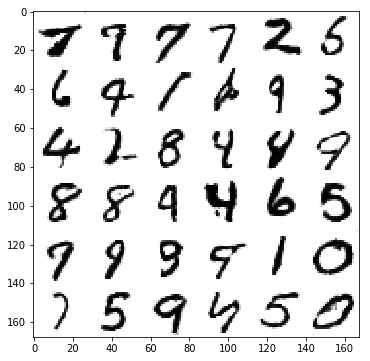

In [0]:
#testing
# generate images from noise, using generator network
n=6
canvas = np.empty((28*n,28*n))
for i in range(n):
  #noise input
  z=np.random.uniform(-1.,1., size=[n,noise_dim])
  #generate image from noise
  g=sess.run(gen_sample, feed_dict={noise_input:z, is_training:False})
  #rescale values to original [0,1] (from tanh -> [-1,1])
  g=-1*(g-1)
  for j in range(n):
    #draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28,28])

plt.figure(figsize=(n,n))    
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()